In [95]:
# importing necessary libraries
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from scipy import stats

from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import NearMiss
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from collections import Counter

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [96]:
# opening the data set and assigning it to a dataframe
df= pd.read_csv('creditcard.csv')

# verifying that dataset was imported correctly 
print(df.head())
print('--------')
print(df.describe())
print('--------')

# checking for null values
print(df.isnull().sum())
print('--------')

# checking for all data dataset columns 
print(df.columns)
print('--------')

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Fraud: 0.17%
Non-Fraud: 99.83%
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V

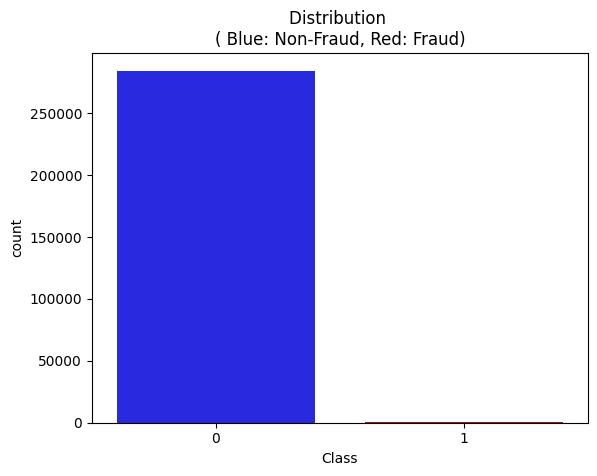

In [97]:
# trying to find what percentage of our data is classified as fraud and what percentage of data is classified as non-fraud
total_count= len(df)
fraud_percentage= df['Class'].value_counts()[1]* 100.0/total_count
non_fraud_percentage= df['Class'].value_counts()[0]* 100.0/total_count
print(f'Fraud: {fraud_percentage:.2f}%\nNon-Fraud: {non_fraud_percentage:.2f}%')
# per the above percentages, it is evident that our dataset is skewwed and will very likely lead to overfitting 
# since it will assume that most transactions are not fraud, however, we would like our model to detect patterns that will 
# potentially indicate fraud

# visualizing the difference in distribution between fraud and non-fraud classified data
custom_palette = ['#0A0AFF', '#AF0000']
sns.countplot(x = 'Class', data=df, palette=custom_palette)
plt.title('Distribution \n( Blue: Non-Fraud, Red: Fraud)')

# scaling data - it is obvious that all features are scaled expect for time and amount, we will scale those fetures
robust_scaler = RobustScaler()
df['scaled_amount']= robust_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time']= robust_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
# replacing unscaled amount and time with scaled_amount and scaled_time respectively
df.drop(['Time', 'Amount'], axis=1, inplace=True)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# rearranging scaled_amount and scaled_time to be the first two columns 
df.insert(0, 'scaled_amount', df.pop('scaled_amount'))
df.insert(1, 'scaled_time', df.pop('scaled_time'))
# verifying
print(df.head())

        scaled_amount  scaled_time        V1        V2         V3        V4  \
114253      -0.097813    -0.132661 -2.428210 -1.946398   1.331855 -1.055566   
44091        1.089779    -0.504012 -7.222731  6.155773 -10.826460  4.180779   
8258        -0.084539    -0.865001 -0.257173  0.643993   1.813137 -0.468893   
30384       -0.293440    -0.573233 -2.857170  4.045601  -4.197299  5.487199   
125342       1.186334    -0.083001 -7.139060  2.773082  -6.757845  4.446456   

              V5        V6        V7        V8  ...       V20       V21  \
114253  2.389640 -3.178324 -0.828897 -0.539544  ... -0.135792  0.078882   
44091  -6.123555 -3.114136 -6.895112  5.161516  ...  0.818859  0.912700   
8258   -0.167437 -0.184434  0.128010  0.029924  ...  0.016801  0.038906   
30384  -3.070776 -1.422686 -5.651314  2.019657  ...  0.981609  1.080323   
125342 -5.464428 -1.713401 -6.485365  3.409395  ... -0.616949  1.303250   

             V22       V23       V24       V25       V26       V27       V

Text(0.5, 1.0, 'Distribution \n(Blue: Non-Fraud, Red: Fraud)')

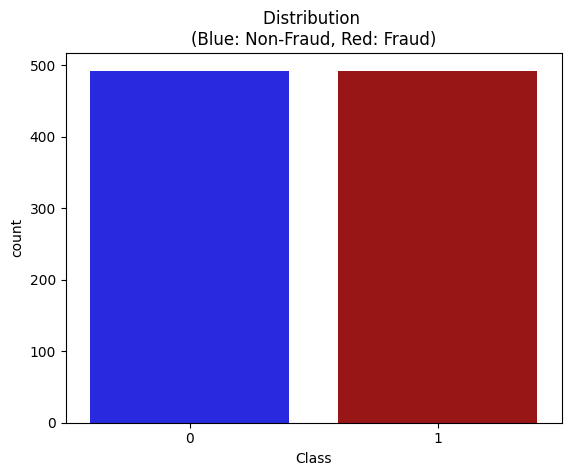

In [98]:
# data split
# preparing feature and target variables
X = df.drop('Class', axis=1)
y = df['Class']

# splitting the data with stratification(80% train and 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# to fix the skewwed data problem, we want to make them equivalent to have a normal distobution of both classes
# shuffling data before creating subsamples
df = df.sample(frac=1)

# extracting fraud class from the dataset
fraud_df = df.loc[df['Class'] == 1]
# taking an equal number of non-fraud classes to have an even distribution of classes
non_fraud_df = df.loc[df['Class'] == 0][:492]

# creating a new dataframe that has an equal number of frad and non-fraud cases - ultimately tackling imbalances
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# shuffling dataframe again for further analysis and training
new_df = normal_distributed_df.sample(frac=1, random_state=42)

# verifying
print(new_df.head())

# checking to see if the classes are evenly distribution
total_count= len(new_df)
fraud_percentage= new_df['Class'].value_counts()[1]* 100.0/total_count
non_fraud_percentage= new_df['Class'].value_counts()[0]* 100.0/total_count
print(f'Fraud: {fraud_percentage:.2f}%\nNon-Fraud: {non_fraud_percentage:.2f}%')

# visualizing the difference in distribution between fraud and non-fraud classified data
custom_palette = ['#0A0AFF', '#AF0000']
sns.countplot(x = 'Class', data=new_df, palette=custom_palette)
plt.title('Distribution \n(Blue: Non-Fraud, Red: Fraud)')

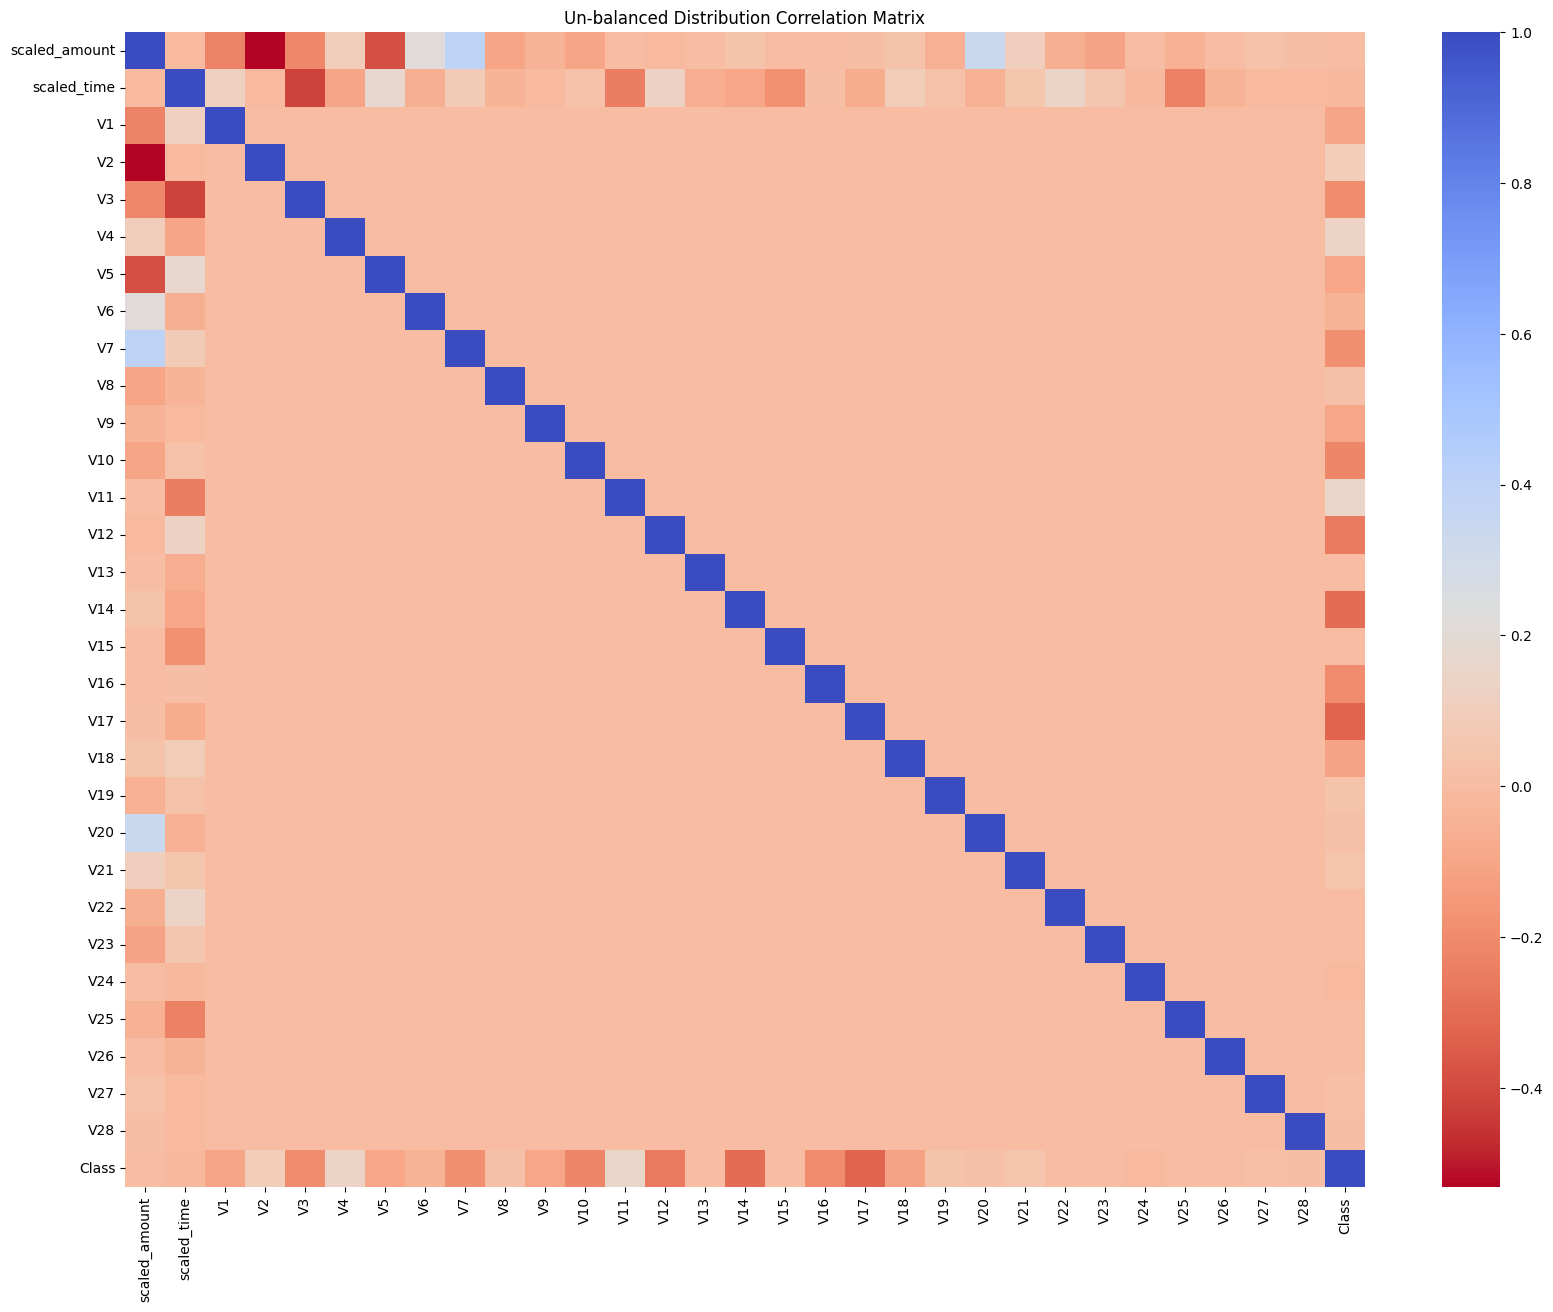

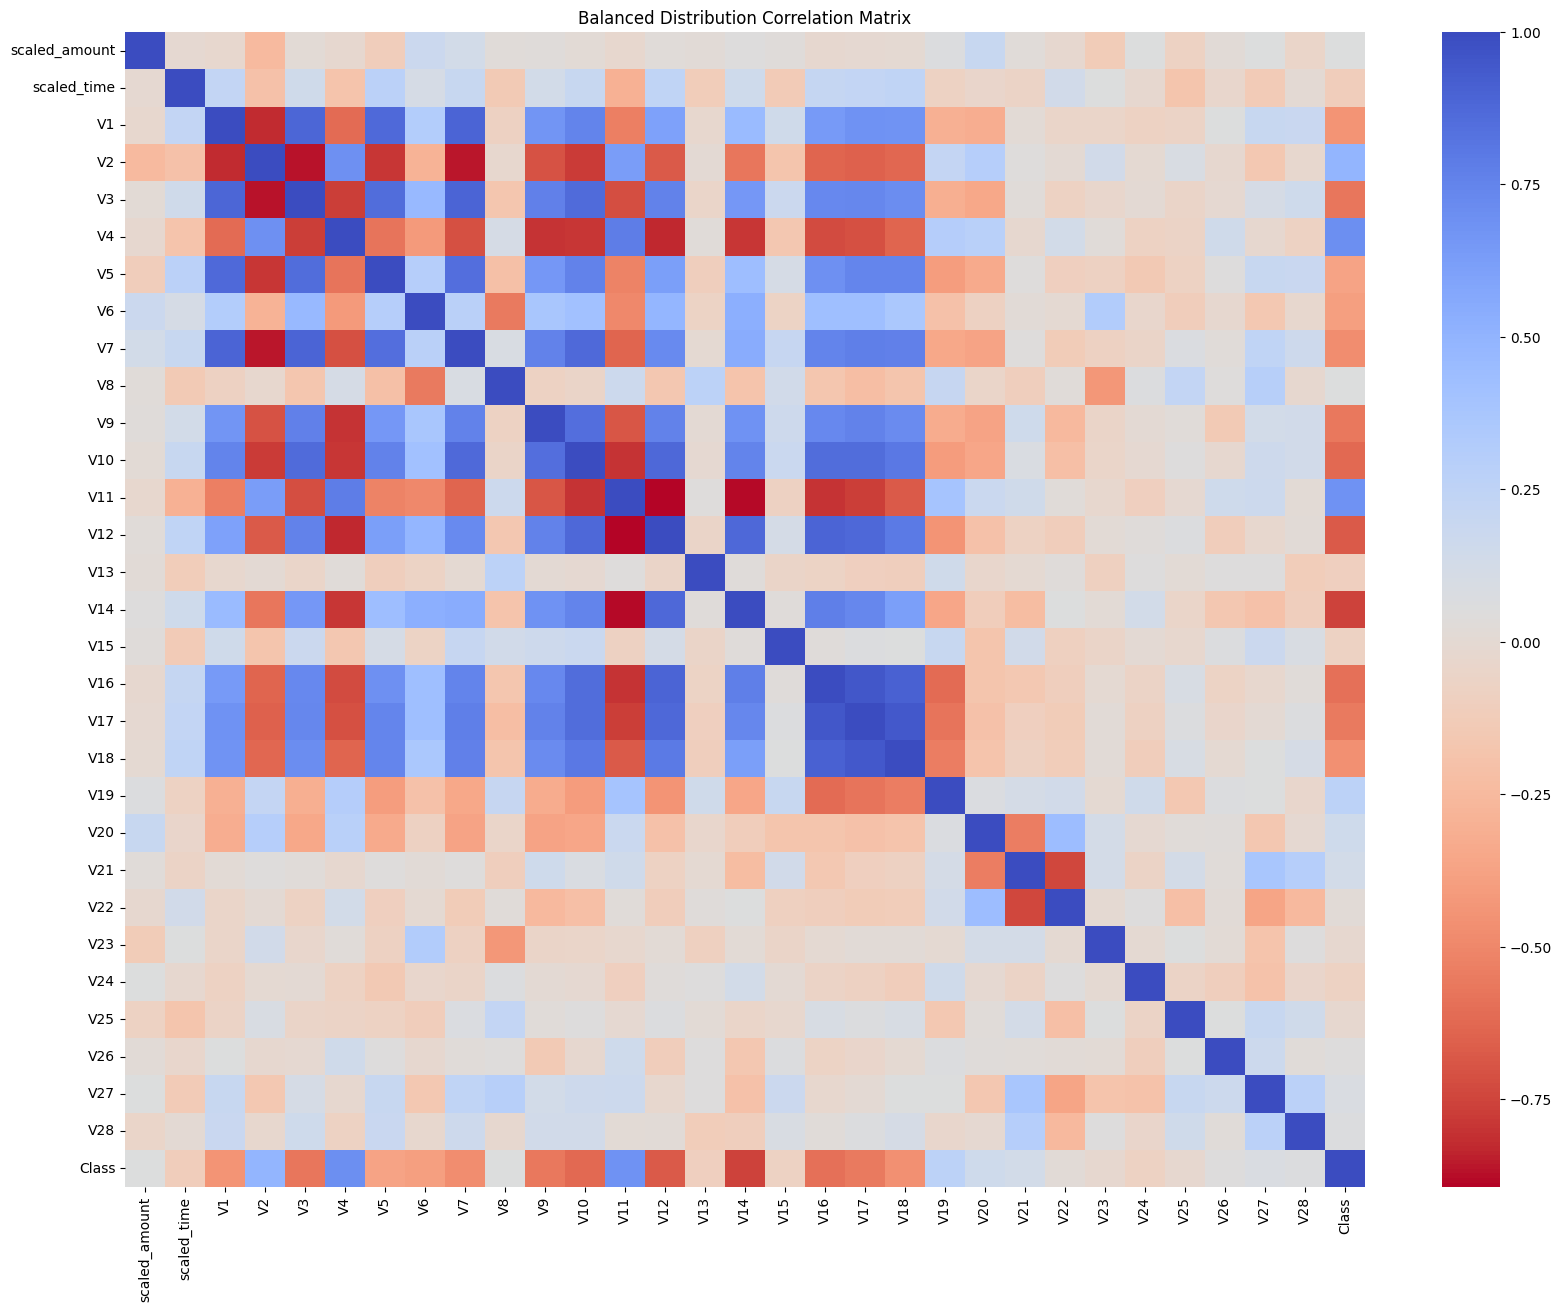

Pre-cleaned DataFrame shape: (984, 31)
Cleaned DataFrame shape: (824, 31)


In [99]:
# correlation matrix - showing how a balanced distribution improves correlation 

# un-balanced distribution
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), cmap='coolwarm_r')
plt.title("Un-balanced Distribution Correlation Matrix")
plt.show()
# balanced distribution
plt.figure(figsize=(20, 15))
sns.heatmap(new_df.corr(), cmap='coolwarm_r')
plt.title('Balanced Distribution Correlation Matrix')
plt.show()

# anomaly detection - removing outliers based on Z-score
def remove_outliers_zscore(df):
    z_scores = stats.zscore(df)
    abs_z_scores= abs(z_scores)
    # filtering the dataframe
    df_cleaned= df[(abs_z_scores < 3).all(axis=1)]
    return df_cleaned

cleaned_df = remove_outliers_zscore(new_df.copy())

# verifying that this actually removed some values
print(f"Pre-cleaned DataFrame shape: {new_df.shape}")
print(f"Cleaned DataFrame shape: {cleaned_df.shape}")

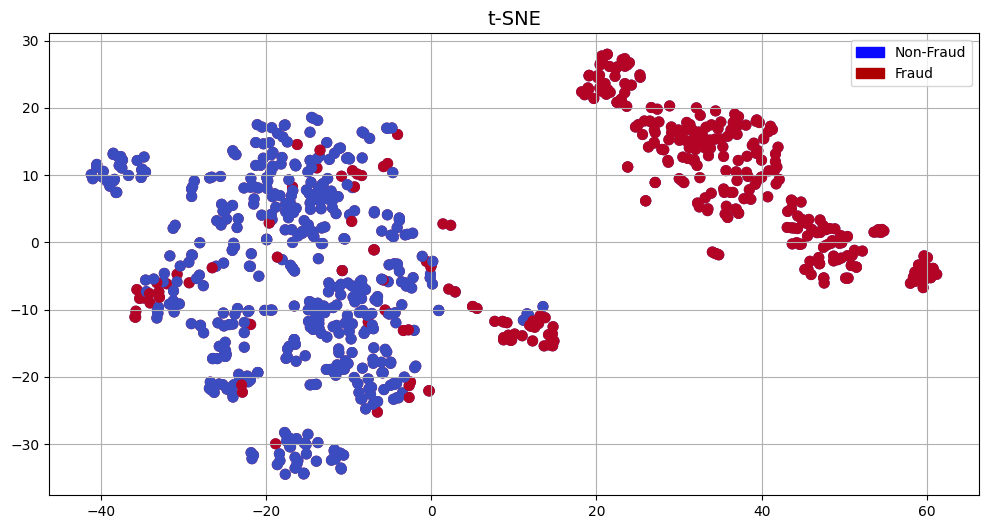

In [100]:
# dimensionality reduction - we are applying dimensionality reduction on the evenly distributed classes to reduce the 
# data into a 2-D space (x, y). This is to see if fraud and non-fraud cases form two different clusters in a 2-D space. 
# This furhter helps in seeing whether or not fraud cases form unique patterns in the dataset. 

# separating features and labels, x contains the features and y contains the target
X = cleaned_df.drop('Class', axis=1)
y = cleaned_df['Class']

# creating a legend
blue_patch = mpatches.Patch(color='#0A0AFF', label='Non-Fraud') 
red_patch = mpatches.Patch(color='#AF0000', label='Fraud') 

# T-SNE Implementation - reduces data to 2-D and clusters similar data points together
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

plt.figure(figsize=(12, 6))
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='Non-Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE', fontsize=14)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])
plt.show()


In [101]:
# introducing a classifier

# separating features and labels, x contains the features and y contains the target
X = cleaned_df.drop('Class', axis=1)
y = cleaned_df['Class']

# since data is already scaled - we are good to proceed with splitting the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# turning values into an array for feeding the classification 
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# initiating the models 
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(),
    'Decision Tree Classifier': DecisionTreeClassifier()
}

# finding which model yields the best accuracy through cross-validation 
for classifier, model in models.items():
    # fitting the model to the training data
    model.fit(X_train, y_train) 
    training_score = cross_val_score(model, X_train, y_train, cv=5) 
    print(f"Classifier: {classifier}, training score: {training_score.mean() * 100:.2f}% accuracy score")  

# based on our results, we will use Logistic Regression since it has the highest training accuracy score

# finding the best Logistic Regression parameters
log_reg_parameters = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_parameters)
# fitting training data
grid_log_reg.fit(X_train, y_train)
# logistic regression with best parameters
log_reg = grid_log_reg.best_estimator_

# finding the best KNN parameters
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
# fitting training data
grid_knears.fit(X_train, y_train)
# KNN with the best parameters
knears_neighbors = grid_knears.best_estimator_

# finding the best suppor vector classifier parameters
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
# fitting training data
grid_svc.fit(X_train, y_train)
# support vector classifier with the best parameters
svc = grid_svc.best_estimator_

# finding the best decision tree classifier parameters
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
# fitting training data
grid_tree.fit(X_train, y_train)
# decision with the best parameters
tree_clf = grid_tree.best_estimator_

Classifier: Logistic Regression, training score: 94.69% accuracy score
Classifier: K-Nearest Neighbors, training score: 93.48% accuracy score
Classifier: Support Vector Classifier, training score: 94.69% accuracy score
Classifier: Decision Tree Classifier, training score: 92.57% accuracy score


In [102]:
# overfitting case

# logistic regression 
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
# KNN
knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
# support vector classifier
svc_score = cross_val_score(svc, X_train, y_train, cv=5)
# decision tree
tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)

print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  95.15%
Knears Neighbors Cross Validation Score 93.93%
Support Vector Classifier Cross Validation Score 95.0%
DecisionTree Classifier Cross Validation Score 93.93%


In [103]:
# undersampling case

# setting up under-sampled variables and seperating the features from the target
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

# splitting the data into training and testing 
undersample_Xtrain, undersample_Xtest, undersample_ytrain, undersample_ytest = train_test_split(
    undersample_X, undersample_y, test_size=0.2, random_state=42, stratify=undersample_y
)

# turning values into an array for feeding the classification 
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

# implementing NearMiss to balance the classes in the training set before fitting the model 
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_Xtrain, undersample_ytrain)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# models
models = {
    'Logistic Regression': log_reg,
    'K-Nearest Neighbors': knears_neighbors,
    'Support Vector Classifier': svc,
    'Decision Tree Classifier': tree_clf
}

# metric storage
undersample_accuracy = {}
undersample_precision = {}
undersample_recall = {}
undersample_f1 = {}
undersample_auc = {}

# lopping through all models
for model_name, model in models.items():
    # fitting the model
    model.fit(X_nearmiss, y_nearmiss)

    # predicting on test data
    undersample_prediction = model.predict(undersample_Xtest)
    
    # calculating metrics
    undersample_accuracy[model_name] = model.score(undersample_Xtest, undersample_ytest)
    undersample_precision[model_name] = precision_score(undersample_ytest, undersample_prediction)
    undersample_recall[model_name] = recall_score(undersample_ytest, undersample_prediction)
    undersample_f1[model_name] = f1_score(undersample_ytest, undersample_prediction)
    undersample_auc[model_name] = roc_auc_score(undersample_ytest, undersample_prediction)
    
    print(f'{model_name} Results:')
    print(f'Accuracy: {undersample_accuracy[model_name]:.2f}')
    print(f'Precision: {undersample_precision[model_name]:.2f}')
    print(f'Recall: {undersample_recall[model_name]:.2f}')
    print(f'F1 Score: {undersample_f1[model_name]:.2f}')
    print(f'AUC: {undersample_auc[model_name]:.2f}\n')
    


NearMiss Label Distribution: Counter({0: 394, 1: 394})
Logistic Regression Results:
Accuracy: 0.76
Precision: 0.01
Recall: 0.91
F1 Score: 0.01
AUC: 0.84

K-Nearest Neighbors Results:
Accuracy: 0.72
Precision: 0.01
Recall: 0.93
F1 Score: 0.01
AUC: 0.82

Support Vector Classifier Results:
Accuracy: 0.57
Precision: 0.00
Recall: 0.93
F1 Score: 0.01
AUC: 0.75

Decision Tree Classifier Results:
Accuracy: 0.50
Precision: 0.00
Recall: 0.89
F1 Score: 0.01
AUC: 0.69



In [104]:
# further metrics

# metrics storage
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []

# models
models = {
    'Logistic Regression': log_reg,
    'K-Nearest Neighbors': knears_neighbors,
    'Support Vector Classifier': svc,
    'Decision Tree Classifier': tree_clf
}

labels = ['No Fraud', 'Fraud']

# looping through models and evaluting each 
for model_name, model in models.items():
    print(f'--- Evaluating {model_name} ---')

    # predicting on training data
    y_pred_train = model.predict(X_train)
    
    # overfitting case
    print('Overfitting:\n')
    print(f'{model_name} - Recall Score: {recall_score(y_train, y_pred_train):.2f}')
    print(f'{model_name} - Precision Score: {precision_score(y_train, y_pred_train):.2f}')
    print(f'{model_name} - F1 Score: {f1_score(y_train, y_pred_train):.2f}')
    print(f'{model_name} - Accuracy Score: {accuracy_score(y_train, y_pred_train):.2f}')
    print('---' * 45)

    # appending to metric storage 
    undersample_accuracy.append(accuracy_score(y_train, y_pred_train))
    undersample_precision.append(precision_score(y_train, y_pred_train))
    undersample_recall.append(recall_score(y_train, y_pred_train))
    undersample_f1.append(f1_score(y_train, y_pred_train))

    # how it should look on cross-validated predictions
    print('How it should be (Cross-Validated Metrics):\n')
    print(f'{model_name} - Accuracy Score: {np.mean(undersample_accuracy):.2f}')
    print(f'{model_name} - Precision Score: {np.mean(undersample_precision):.2f}')
    print(f'{model_name} - Recall Score: {np.mean(undersample_recall):.2f}')
    print(f'{model_name} - F1 Score: {np.mean(undersample_f1):.2f}')
    print('---' * 45)
    
    # predcting on test data using the undersampled test set
    smote_prediction = model.predict(undersample_Xtest)
    
    # classification report
    print(f'Classification Report for {model_name} on test set:\n')
    print(classification_report(undersample_ytest, smote_prediction, target_names=labels))
    print('---' * 45)

# key points to note:
# overfitting: training score is much higher than validation score - model struggles to generalize to unseen data
# underfitting: training and validation scores are low and close - model is not learning enough from the data

--- Evaluating Logistic Regression ---
Overfitting:

Logistic Regression - Recall Score: 0.91
Logistic Regression - Precision Score: 0.77
Logistic Regression - F1 Score: 0.83
Logistic Regression - Accuracy Score: 0.84
---------------------------------------------------------------------------------------------------------------------------------------
How it should be (Cross-Validated Metrics):

Logistic Regression - Accuracy Score: 0.84
Logistic Regression - Precision Score: 0.77
Logistic Regression - Recall Score: 0.91
Logistic Regression - F1 Score: 0.83
---------------------------------------------------------------------------------------------------------------------------------------
Classification Report for Logistic Regression on test set:

              precision    recall  f1-score   support

    No Fraud       1.00      0.76      0.87     56864
       Fraud       0.01      0.91      0.01        98

    accuracy                           0.76     56962
   macro avg       0.5

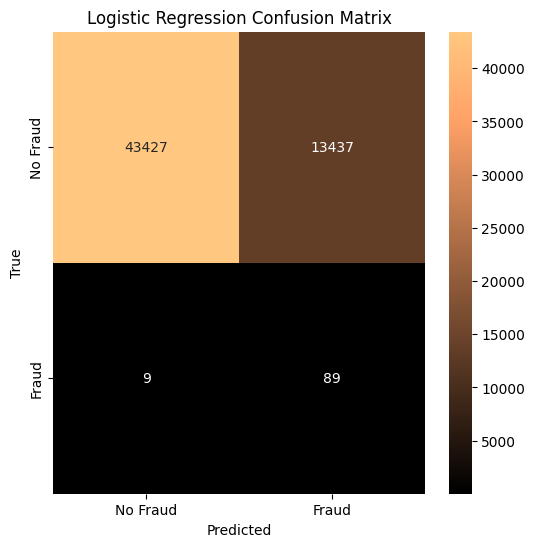

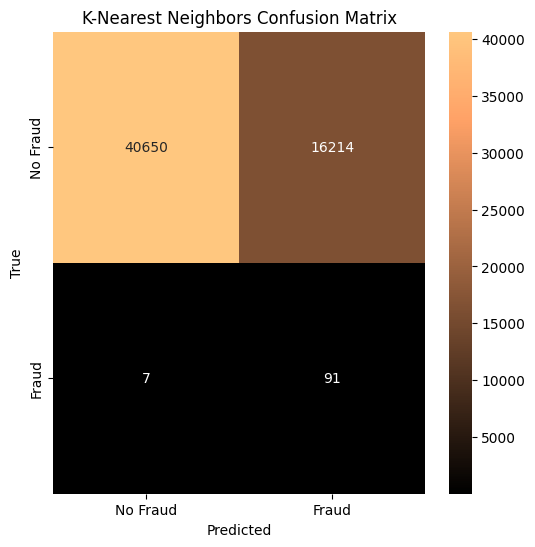

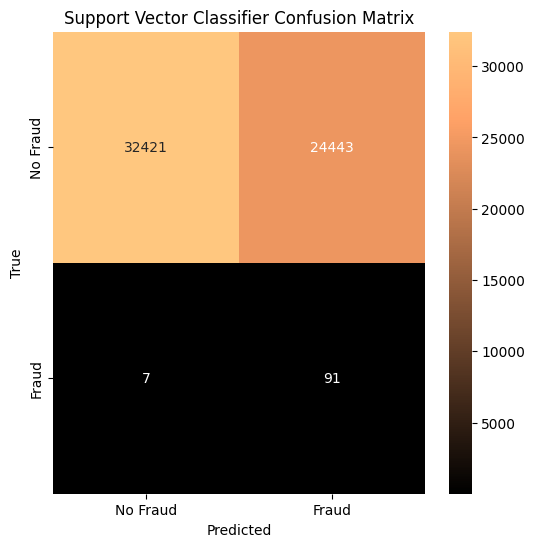

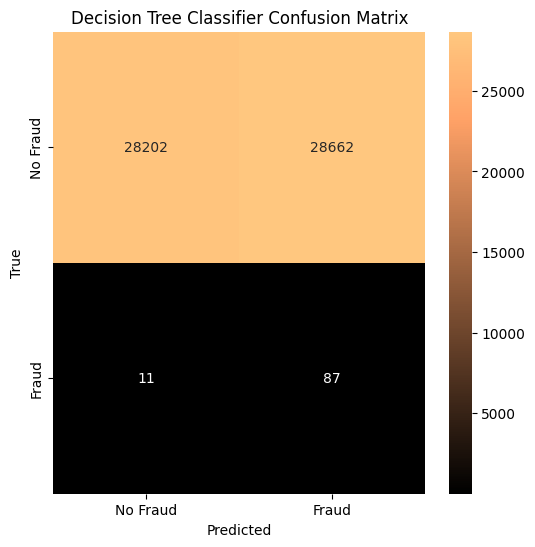

In [105]:
# confusion matrix

for model_name, model in models.items():
    # predicting on undersampled test data for confusion matrix
    smote_prediction = model.predict(undersample_Xtest)
    
    # calculating the confusion matrix 
    confusion_mat = confusion_matrix(undersample_ytest, smote_prediction)

    # plotting
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='copper', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# key points to note: 
# True Negatives | top-left square: correctly classified no fraud detected
# False Negatives | top-right square: incorrectly classified no fraud detected
# False Positive | bottom-left square: incorrectly classified fraud detected 
# True Positive | bottom-right square: correctly classified fraud detected